In [4]:
# 파이썬≥3.5 필수
import sys
assert sys.version_info >= (3, 5)
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
# 깔끔한 그래프 출력을 위해 %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
from matplotlib import font_manager, rc
import platform
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False
# Jupyter Notebook의 출력을 소수점 이하 3자리로 제한
%precision 3
# 그래픽 출력을 조금 더 고급화하기 위한 라이브러리
import seaborn as sns

#과학 기술 통계 라이브러리
import scipy as sp
from scipy import stats
# 사이킷런 ≥0.20 필수 : 0.20에서 데이터 변환을 위한 Transformer클래스가 추가됨
import sklearn
assert sklearn.__version__ >= "0.20"

# 데이터를 분할할 때 동일한 분할을 만들기 위해서
# 모델을 만드는 작업을 여러 번에 걸쳐서 하는 경우 시드가 변경이 되서 훈련용 데이터가
# 자주 변경이 되면 결국 모든 데이터를 가지고 모델을 생성하는 결과
# Overfit이 될 가능성이 높아짐
np.random.seed(42)


## MINIST Data

In [6]:
# 데이터 다운로드
# 디셔너리 형태로 다운로드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [8]:
# 피쳐와 타겟 가져오기
X, y = mnist['data'], mnist['target']
print(X.shape)
# 데이터는 784 픽셀을 가진 흑백 이미지로 실제 크기는 28 * 28
# 각 픽셀은 0~255 까지의 값
print(y.shape)

(70000, 784)
(70000,)


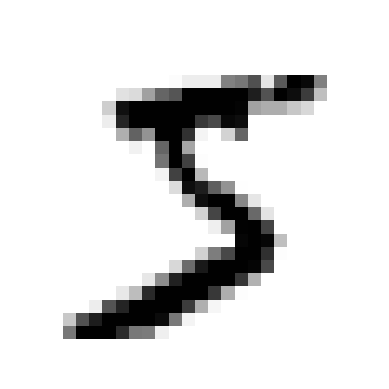

In [16]:
# 하나의 이미지 출력
some_digit=X[0] # 이 이미지는 784 픽셀로 구성
some_digit_image = some_digit.reshape(28,28) # 2차원 이미지로 변환
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis('off')
plt.show()

In [17]:
# 출력한 이미지의 레이블을 확인
print(y[0])

5


In [24]:
# 여러 개의 이미지를 출력하기 위한 함수
# 첫 번째 매개변수는 이미지
# 두 번째 매개변수는 하나의 행에 출력할 이미지의 수 : 기본값은 10
# 세 번째 매개변수는 옵션으로 디셔너리를 설정
# 여러 개의 옵션을 설정해야 하는 경우 각 매개변수를 나열하는 것은 함수의 가독성을 떨어뜨림
# 이런 경우에는 매개변수를 하나로 묶어야 하는데 dict나 class
# 생략이 가능한 옵션을 많이 가지고 있으면 dict가 낫고 그렇지 않으면 class를 사용


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    # 행에 출력할 이미지의 개수를 설정
    images_per_row = min(len(instances), images_per_row)
    # 이미지 크기 설정
    images = [instance.reshape(size,size) for instance in instances]
    # 행의 개수를 출력
    n_rows = (len(instances)-1) // images_per_row+1
    # 이미지들을 저장할 리스트
    row_images = []
    n_empty = n_rows*images_per_row - len(instances)
    
    # 0으로 가득찬 행렬을 만들어서 row_images에 저장
    images.append(np.zeros((size, size * n_empty)))
    
    # 행 단위로 순회하면서 실제 이미지를 추가
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    #이미지 출력
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off") 
    

그림 저장: more_digits_plot


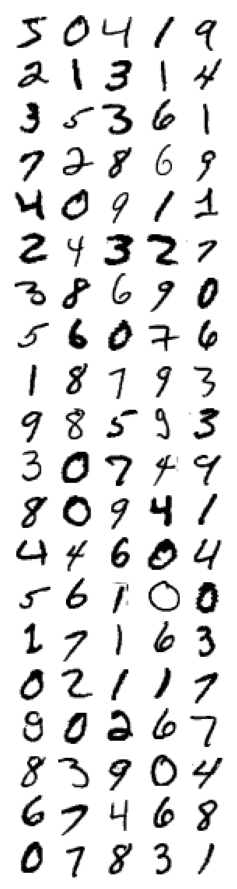

In [25]:
# 여러 개의 이미지 출력 함수 확인
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=5)
save_fig("more_digits_plot")
plt.show()

In [28]:
# 타겟의 자료형 확인
print(type(y[0]))
# 범주형 데이터의 자료형은 정수를 권장
# 타겟의 자료형 변경
# 간혹 np.int로 변경하는 경우가 있는데 numpy 버전이 변경되면서 없어짐
y = y.astype(np.uint8)
print(type(y[0]))

<class 'numpy.uint8'>
<class 'numpy.uint8'>


## 이진 분류를 위한 데이터 생성

In [31]:
# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류는 True 와 False로 분류
# 이진 분류의 경우는 Target이 bool
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
print(y_train_5[0])

True


## SGDClassifier를 이용한 이진분류

### 훈련 및 데이터 예측

In [34]:
from sklearn.linear_model import SGDClassifier

#훈련에 사용할 모델을 생성 - 하이퍼 파라미터를 설정
#max_iter는 최대 반복 횟수
#tol은 정밀도
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

#훈련
sgd_clf.fit(X_train, y_train_5)

#예측 - feature는 2차원 배열 이상이어야 함
sgd_clf.predict([some_digit])

array([ True])

### k겹 교차 검증을 이용한 정확도 측정

In [35]:
from sklearn.model_selection import cross_val_score
# 3번 교차 검증을 수행하는데 평가 지표는 정확도
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95, 0.96, 0.96])

In [38]:
# 새로운 분류기를 가지고 훈련하고 교차 검증
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.911, 0.909, 0.909])

## 오차 행렬(confusion matrix)

In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
# 확률적 경사 하강법 모델을 가지고 훈련한 후 값을 예측
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# 오차 행렬 출력
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [42]:
#다른 평가 지표 계산
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("정확도:", accuracy_score(y_train_5, y_train_pred))
print("정밀도:", precision_score(y_train_5, y_train_pred))
print("재현율:", recall_score(y_train_5, y_train_pred))
print("f1_score:", f1_score(y_train_5, y_train_pred))

정확도: 0.9570333333333333
정밀도: 0.8370879772350012
재현율: 0.6511713705958311
f1_score: 0.7325171197343846


In [46]:
# 결정 임계값 - 기본 값은 0
# 자신의 점수를 출력
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores) # 임계값인 0 보다 크기 때문에 True

# 전체 훈련 데이터의 점수를 출력
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
print(y_scores)

[2164.22]
[  1200.931 -26883.792 -33072.035 ...  13272.127  -7258.472 -16877.508]


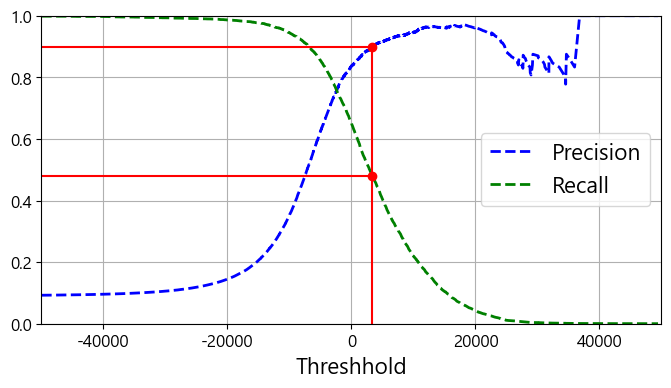

In [56]:
# 정밀도와 재현율 트레이드 오프
from sklearn.metrics import precision_recall_curve
# 정밀도, 재현율, 임계값을 전부 추출
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# 정밀도와 재현율 그래프를 그려주는 함수
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshhold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
plt.figure(figsize=(8,4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#정밀도가 0.9가 되는 위치의 재현율 조회
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.plot([threshold_90_precision, threshold_90_precision], [0,0.9], "r")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r")
plt.plot([-50000, threshold_90_precision,],[recall_90_precision, recall_90_precision], "r")

plt.plot([threshold_90_precision],[0.9],"ro")
plt.plot([threshold_90_precision],[recall_90_precision],"ro")
plt.show()

In [58]:
# 정밀도가 0.9가 되는 지점을 이용해서 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)
# 정밀도
print(precision_score(y_train_5, y_train_pred_90))
# 재현율
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### ROC 곡선

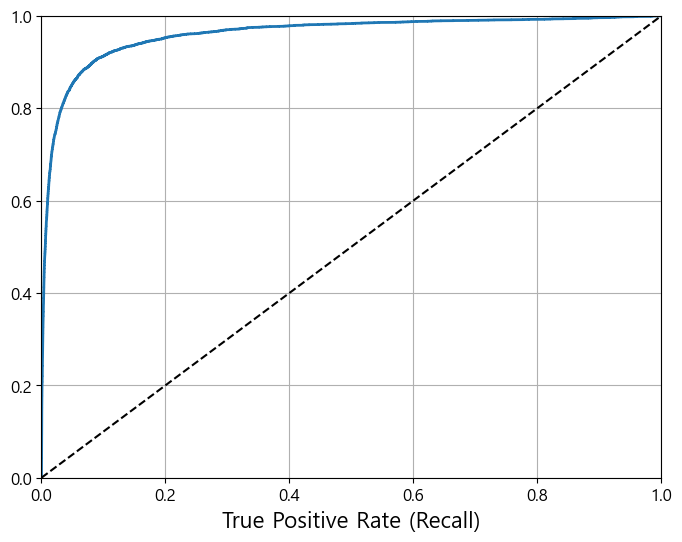

In [59]:
from sklearn.metrics import roc_curve

#그래프 사용할 값 계산
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') #대각선 - 완전 랜덤인 경우
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.xlabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
    
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

In [61]:
# ROC 곡선의 면적
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


## 다중 분류

### 이진 분류기를 이용한 다중 분류

In [64]:
from sklearn.svm import SVC
# 이진 분류기
svm_clf = SVC(gamma="auto", random_state=42)
# 이진 분류기를 이용해서 0 - 9 까지 10개를 분류
svm_clf.fit(X_train[:1000], y_train[:1000])
print(svm_clf.predict([some_digit]))
# 결정 점수를 확인
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[5]
[[ 2.816  7.092  3.83   0.794  5.889  9.297  1.799  8.104 -0.228  4.838]]


### SGD를 이용한 다중 분류

In [67]:
sgd_clf.fit(X_train, y_train)
# 예측
print(sgd_clf.predict([some_digit]))
# 결정 점수 확인
print(sgd_clf.decision_function([some_digit]))

[3]
[[-31893.031 -34419.691  -9530.64    1823.732 -22320.148  -1385.805
  -26188.911 -16147.513  -4604.355 -12050.767]]


In [68]:
# 교차 검증을 이용한 정확도 확인
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.874, 0.858, 0.869])

In [70]:
# 특성이 여러 개이고 이 특성의 값의 분포가 일정하지 않은 경우
# scailing 이나 standardization을 고려
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.898, 0.891, 0.902])

In [71]:
y_train_predict = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5860   63    0    0    0    0    0    0    0    0]
 [6675   67    0    0    0    0    0    0    0    0]
 [5932   26    0    0    0    0    0    0    0    0]
 [5913  218    0    0    0    0    0    0    0    0]
 [5821   21    0    0    0    0    0    0    0    0]
 [1891 3530    0    0    0    0    0    0    0    0]
 [5796  122    0    0    0    0    0    0    0    0]
 [6251   14    0    0    0    0    0    0    0    0]
 [5741  110    0    0    0    0    0    0    0    0]
 [5903   46    0    0    0    0    0    0    0    0]]


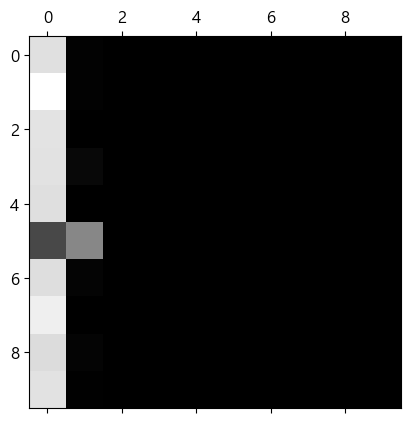

In [72]:
# 오차 행렬을 시각화
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

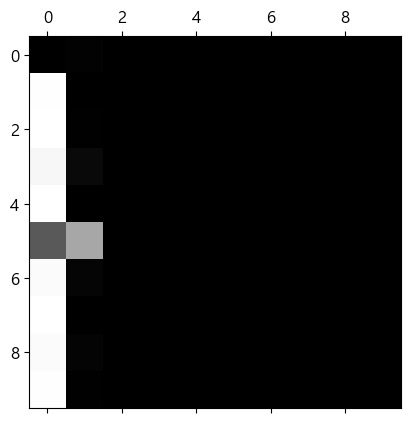

In [73]:
# 오차 행렬을 각 행의 합계로 나누고 대각선을 0으로 채워서 오류를 조금 더 눈에 띄게 출력
# 분류 모델에서는 이 행렬을 반드시 출력해보는 것이 좋음
# 잘못 분류된 모델을 확인해 볼 수 있음
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
# 주 대각선 방향을 0으로 채움
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

### 다중 레이블 분류

In [76]:
# 출력해야 할 레이블이 여러 개인 경우
# 이미지를 가지고 7보다 큰지 그리고 홀수인지 여부를 같이 리턴해야 하는 경우
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
# 2개를 가지고 MultiLabel 생성
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

## 분류 알고리즘

### LDA(선형 판별 분석)

In [78]:
# borrowscore와 payment_inc_ratio에 따른 outcome 선형 판별 분석
loan3000 = pd.read_csv("./data/data/data/loan3000.csv")
print(loan3000.head())
loan3000.info()

   Unnamed: 0   outcome            purpose_    dti  borrower_score  \
0       32109  paid off  debt_consolidation  21.23            0.40   
1       16982   default         credit_card  15.49            0.40   
2       25335  paid off  debt_consolidation  27.30            0.70   
3       34580  paid off      major_purchase  21.11            0.40   
4       14424   default  debt_consolidation  16.46            0.45   

   payment_inc_ratio  
0            5.11135  
1            5.43165  
2            9.23003  
3            2.33482  
4           12.10320  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3000 non-null   int64  
 1   outcome            3000 non-null   object 
 2   purpose_           3000 non-null   object 
 3   dti                3000 non-null   float64
 4   borrower_score     3000 non-null   float64

In [79]:
# 타겟을 범주형으로 변환
loan3000.outcome = loan3000.outcome.astype("category")

print(loan3000.corr())
# 독립 변수와 종속 변수를 설정
predictors = ['borrower_score', 'payment_inc_ratio']
outcome='outcome'

# 독립 변수 - feature
X = loan3000[predictors]
# 종속 변수 - target
y = loan3000[outcome]

print(X)
print(y)



                   Unnamed: 0       dti  borrower_score  payment_inc_ratio
Unnamed: 0           1.000000 -0.095606        0.249030          -0.102143
dti                 -0.095606  1.000000       -0.258860           0.232972
borrower_score       0.249030 -0.258860        1.000000          -0.109575
payment_inc_ratio   -0.102143  0.232972       -0.109575           1.000000
      borrower_score  payment_inc_ratio
0               0.40            5.11135
1               0.40            5.43165
2               0.70            9.23003
3               0.40            2.33482
4               0.45           12.10320
...              ...                ...
2995            0.50           18.36620
2996            0.60            1.80421
2997            0.20           15.42180
2998            0.45            8.92335
2999            0.40           12.88190

[3000 rows x 2 columns]
0       paid off
1        default
2       paid off
3       paid off
4        default
          ...   
2995    paid off
2

C:\Users\USER\AppData\Local\Temp\ipykernel_3704\2849596509.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(loan3000.corr())


In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
# 최적의 값을 확인
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [83]:
# 처음 5개의 데이터 판별
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]), columns=loan_lda.classes_)
print(pred.head())

# 결과 해석(default와 paid_off의 확률을 확인)
# 첫번째 데이터가 default일 확률이 55.3544%, paid off일 확률이 44.6456%

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


#### loan_200.csv 파일의 데이터를 읽어서 payment_inc_ratio와 dti를 이용해서 outcome을 예측

In [85]:
from sklearn.neighbors import KNeighborsClassifier

# 데이터 불러오기
loan200 = pd.read_csv('./data/data/data/loan200.csv')

predictors = ["payment_inc_ratio", "dti"]
outcome = 'outcome'

# 테스트 데이터와 예측 변수 및 타겟 벡터 분리
# newloan이라는 이름으로 데이터 하나 빼두기
newloan = loan200.loc[0:0, predictors]
X = loan200.loc[1:, predictors]
y = loan200.loc[1:, outcome]
print(X)
print(y)


     payment_inc_ratio    dti
1              5.46933  21.33
2              6.90294   8.97
3             11.14800   1.83
4              3.72120  10.81
5              1.89923  11.34
..                 ...    ...
196           11.66300  26.09
197            2.97641  16.41
198            1.96846  19.98
199            9.64200  20.17
200            7.03924  13.88

[200 rows x 2 columns]
1       default
2      paid off
3      paid off
4       default
5      paid off
         ...   
196     default
197     default
198     default
199    paid off
200    paid off
Name: outcome, Length: 200, dtype: object


In [87]:
# 판별할 이웃의 개수 설정
knn = KNeighborsClassifier(n_neighbors=20)
#훈련 
knn.fit(X, y)
#예측
knn.predict(newloan)

#결과 'paid off' 로 나옴

# 확률 확인
knn.predict_proba(newloan)
# 결과
# array([[0.45, 0.55]]) -> default 확률이 45%, paid off 확률이 55%

array([[0.45, 0.55]])

#### 표준화를 수행한 경우와의 차이

In [88]:
loan_data = pd.read_csv('./data/data/data/loan_data.csv.gz')
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],categories=['paid off', 'default'],ordered=True)

predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
newloan = loan_data.loc[0:0, predictors]
print(newloan)

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4


In [89]:
#정규화를 하지 않은 경우 가까운 5개의 이웃 구하기
X = loan_data.loc[1:, predictors]
y = loan_data.loc[1:, outcome]

#표준화를 하지 않으면 이웃을 찾을 때 특정 특성이 영향을 많이 미치게 됨
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

#상대적으로 revol_bal이 가까운 데이터가 선택되게 됨
nbrs = knn.kneighbors(newloan)
print(X.iloc[nbrs[1][0], :])



       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


In [91]:
# 정규화를 수행한 후 이웃 구하기
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(X*1.0) # 정수를 실수로 만들기

# 정규화
X_std = scaler.transform(X * 1.0)
newloan_std = scaler.transform(newloan * 1.0)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_std, y)

#이전에 비해서 revol_bal을 제외한 속성의 거리들이 가까워짐
nbrs = knn.kneighbors(newloan_std)
print(X.iloc[nbrs[1][0], :])

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


## Logistic Regression

### 붓꽃의 이진 분류 - virginica 인지 아닌지 여부

In [93]:
# 데이터 가져오기
from sklearn import datasets
iris = datasets.load_iris()
#list(iris.keys())

#피처 생성
X = iris['data'][:, 3:]
y = (iris['target'] == 2).astype(np.uint8)
print(X)
print(y)



[[0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.1]
 [0.1]
 [0.2]
 [0.4]
 [0.4]
 [0.3]
 [0.3]
 [0.3]
 [0.2]
 [0.4]
 [0.2]
 [0.5]
 [0.2]
 [0.2]
 [0.4]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.4]
 [0.1]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [0.1]
 [0.2]
 [0.2]
 [0.3]
 [0.3]
 [0.2]
 [0.6]
 [0.4]
 [0.3]
 [0.2]
 [0.2]
 [0.2]
 [0.2]
 [1.4]
 [1.5]
 [1.5]
 [1.3]
 [1.5]
 [1.3]
 [1.6]
 [1. ]
 [1.3]
 [1.4]
 [1. ]
 [1.5]
 [1. ]
 [1.4]
 [1.3]
 [1.4]
 [1.5]
 [1. ]
 [1.5]
 [1.1]
 [1.8]
 [1.3]
 [1.5]
 [1.2]
 [1.3]
 [1.4]
 [1.4]
 [1.7]
 [1.5]
 [1. ]
 [1.1]
 [1. ]
 [1.2]
 [1.6]
 [1.5]
 [1.6]
 [1.5]
 [1.3]
 [1.3]
 [1.3]
 [1.2]
 [1.4]
 [1.2]
 [1. ]
 [1.3]
 [1.2]
 [1.3]
 [1.3]
 [1.1]
 [1.3]
 [2.5]
 [1.9]
 [2.1]
 [1.8]
 [2.2]
 [2.1]
 [1.7]
 [1.8]
 [1.8]
 [2.5]
 [2. ]
 [1.9]
 [2.1]
 [2. ]
 [2.4]
 [2.3]
 [1.8]
 [2.2]
 [2.3]
 [1.5]
 [2.3]
 [2. ]
 [2. ]
 [1.8]
 [2.1]
 [1.8]
 [1.8]
 [1.8]
 [2.1]
 [1.6]
 [1.9]
 [2. ]
 [2.2]
 [1.5]
 [1.4]
 [2.3]
 [2.4]
 [1.8]
 [1.8]
 [2.1]
 [2.4]
 [2.3]
 [1.9]

In [96]:
from sklearn.linear_model import LogisticRegression

# 분류 모델 생성
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
# 모델 훈련
log_reg.fit(X,y)

# 샘플 데이터를 1000개를 생성해서 예측
X_new = np.linspace(0,3,1000).reshape(-1,1)
# 각 샘플의 확률을 계산
y_proba = log_reg.predict_proba(X_new)
# 경계 점수 - 이 값보다 크면 virginica 그렇지 않으면 virginica 가 아님
decision_boundary = X_new[y_proba[:,1] >=0.5][0]
print(decision_boundary)

# 결과 : 1.661 -> 1.661을 기준으로 virginica 인지 아닌지 분류


# 예측
print(log_reg.predict([[1.7],[1.5]]))

[1.661]
